In [477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Encoding | Codificación
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# To save models
import json
import pickle
# Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import mean_squared_error, r2_score

## Paso 1: Planteamiento del problema

Queremos saber cuál va a ser la prima (coste) que debe asumir cada uno de los clientes.



## Paso 2: Exploración y limpieza de datos

In [478]:
archivo = "../data/raw/medical_insurance_cost.csv"
df = pd.read_csv(archivo)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Paso 3: Análisis Descriptivo

`age`.(numérico) Edad del beneficiario principal   
`sex`.(categórico) Género del beneficiario principal   
`bmi`.(numérico) índice de masa corporal   
`children`.(numérico) Número de niños/dependientes cubiertos por un seguro médico   
`smoker`.(categórico) ¿Es fumador?   
`region`.(categórico) Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste   
`charges`.(numérico) Prima del seguro médico   

In [479]:
df.shape

(1338, 7)

In [480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [481]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


## Paso 4: Limpieza de Datos

### Limpieza de datos: Eliminar duplicados

In [482]:
df.duplicated().sum()

np.int64(1)

In [483]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.duplicated().sum()


np.int64(0)

### Limpieza de datos: Eliminar información irrelevante

## Paso 5: Análisis de Variables

### Análisis de Variables Univariante Categóricas


In [484]:
categorical_variables = df.select_dtypes(include=['object']).columns.tolist()
categorical_variables

['sex', 'smoker', 'region']

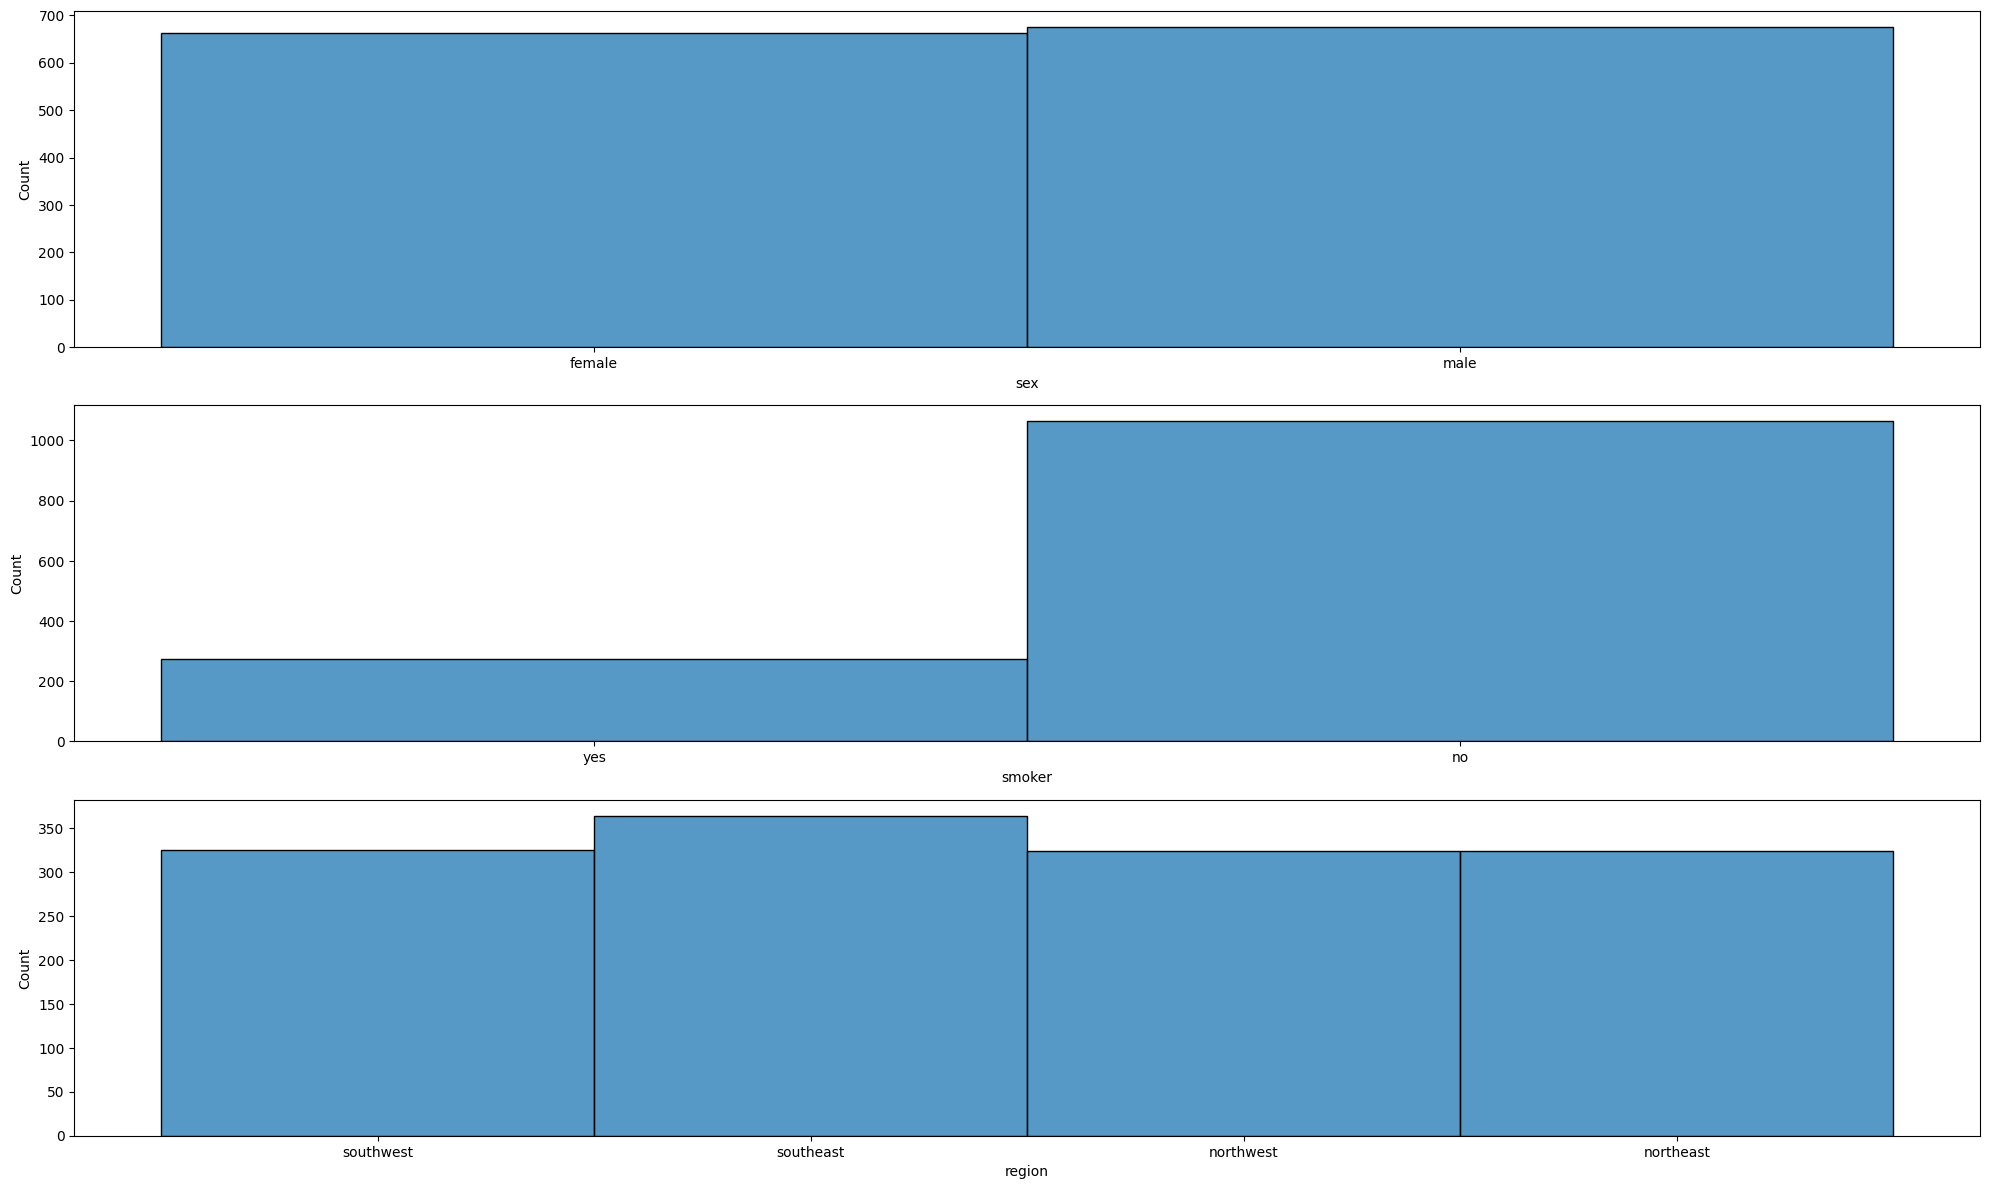

In [485]:
fig, axis = plt.subplots(len(categorical_variables), 1, figsize=(20, 4*len(categorical_variables)))

row = 0
for var in categorical_variables:
    sns.histplot(ax=axis[row], data=df, x=var)
    row += 1

plt.tight_layout()
plt.show()

## Observaciones.

>Solo en `smoker` vemos que los datos hay una clara diferencia, en el resto vemos todo bastante normal.

### Análisis de Variables Univariante Numéricas

In [486]:
num_variables = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_variables

['age', 'bmi', 'children', 'charges']

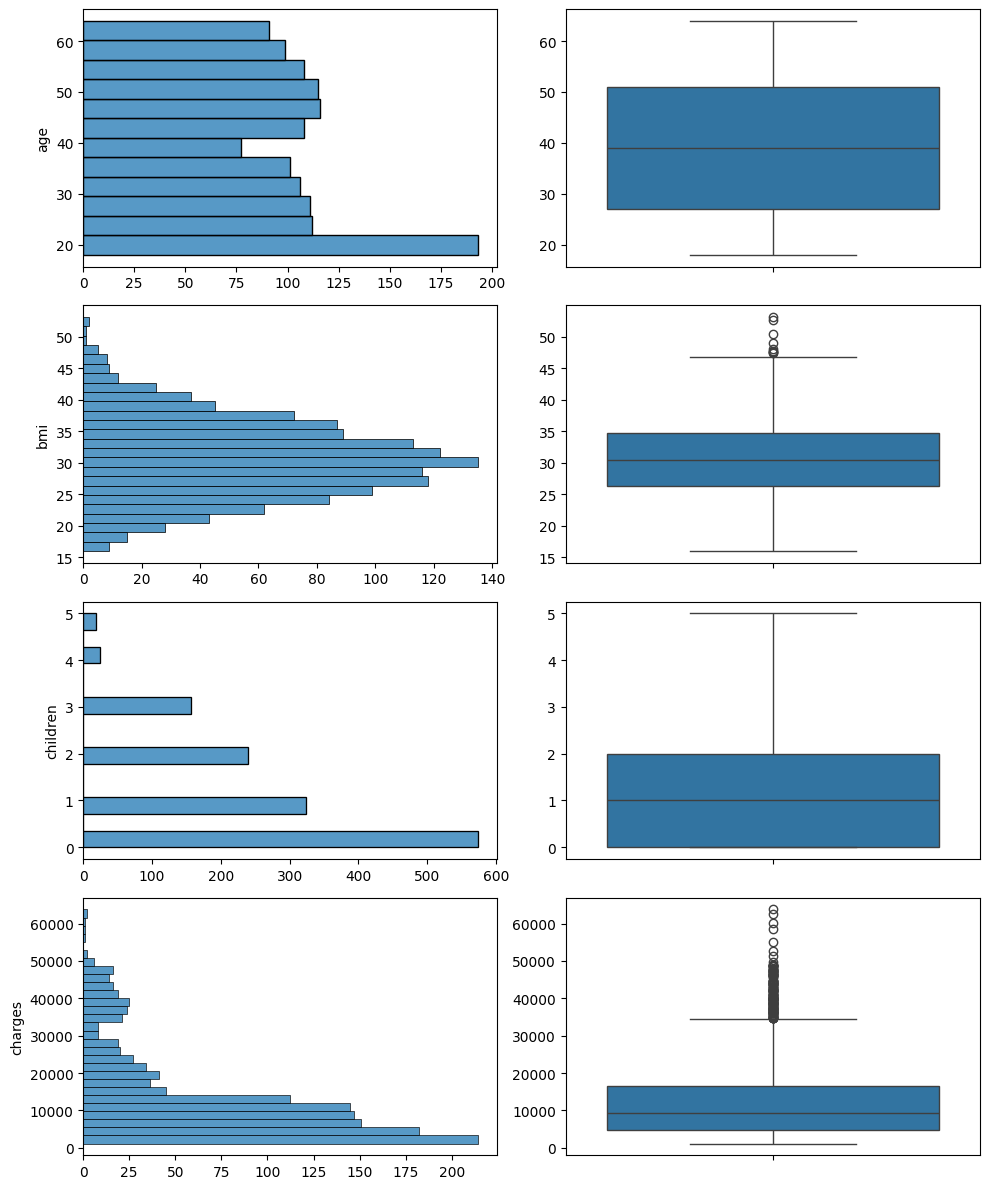

In [487]:
fig, axis = plt.subplots(len(num_variables), 2, figsize=(10, 3*len(num_variables)))

for i, var in enumerate(num_variables):
    sns.histplot(ax=axis[i, 0], data=df, y=var).set(xlabel=None)
    sns.boxplot(ax=axis[i, 1], data=df, y=var).set(ylabel=None)


plt.tight_layout()
plt.show()

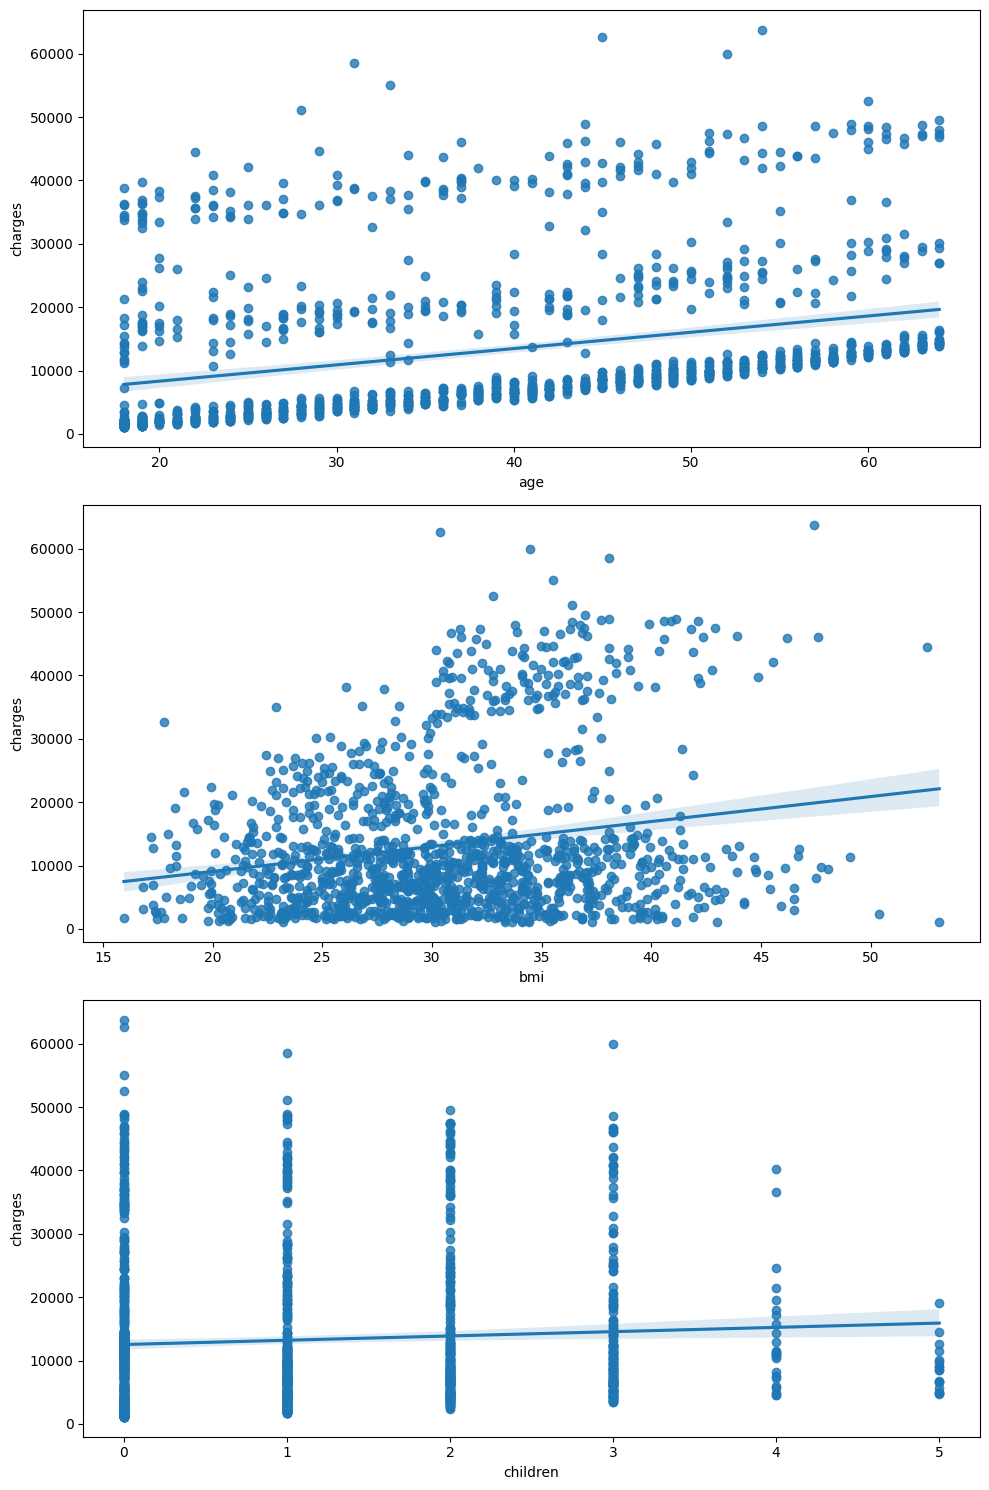

In [488]:
fig, axis = plt.subplots(3, 1, figsize = (10, 15))

sns.regplot(ax = axis[0], data = df, x = "age", y = "charges")
sns.regplot(ax = axis[1], data = df, x = "bmi", y = "charges")
sns.regplot(ax = axis[2], data = df, x = "children", y = "charges")

plt.tight_layout()

plt.show()

### Factorizamos para crear correlaciones con todas las variables.

In [489]:
categorical_variables = df.select_dtypes(include=['object']).columns.tolist()
df_copy = df.copy()
rules = {}

for var in categorical_variables:
    codes, uniques = pd.factorize(df[var])
    df_copy[var] = codes  
    rules[var] = {bat: code for code, bat in enumerate(uniques)}
rules

{'sex': {'female': 0, 'male': 1},
 'smoker': {'yes': 0, 'no': 1},
 'region': {'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3}}

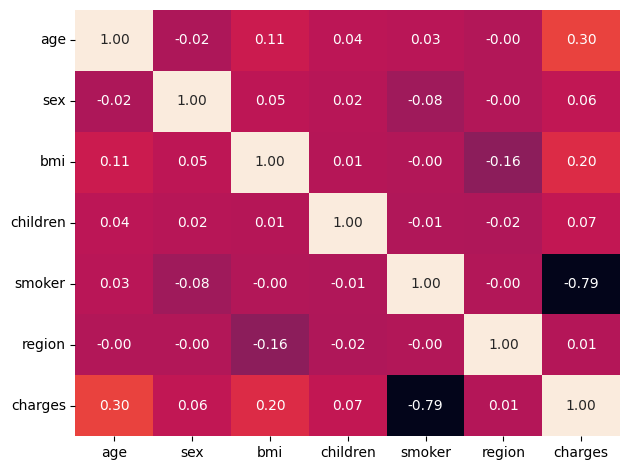

In [490]:
corr_y = df_copy.corr(numeric_only=True)

sns.heatmap(data=corr_y, annot=True, fmt=".2f", cbar=False)

plt.tight_layout()
plt.show()


### Observaciones.

>Como vemos que `region` y `children` no parece afectar los costes entonces lo borramos.

### Análisis categórico-categórico

In [491]:
df.drop(["region","sex"],
              axis=1, inplace=True)
num_variables = df.select_dtypes(include=['int64','float64']).columns.tolist()

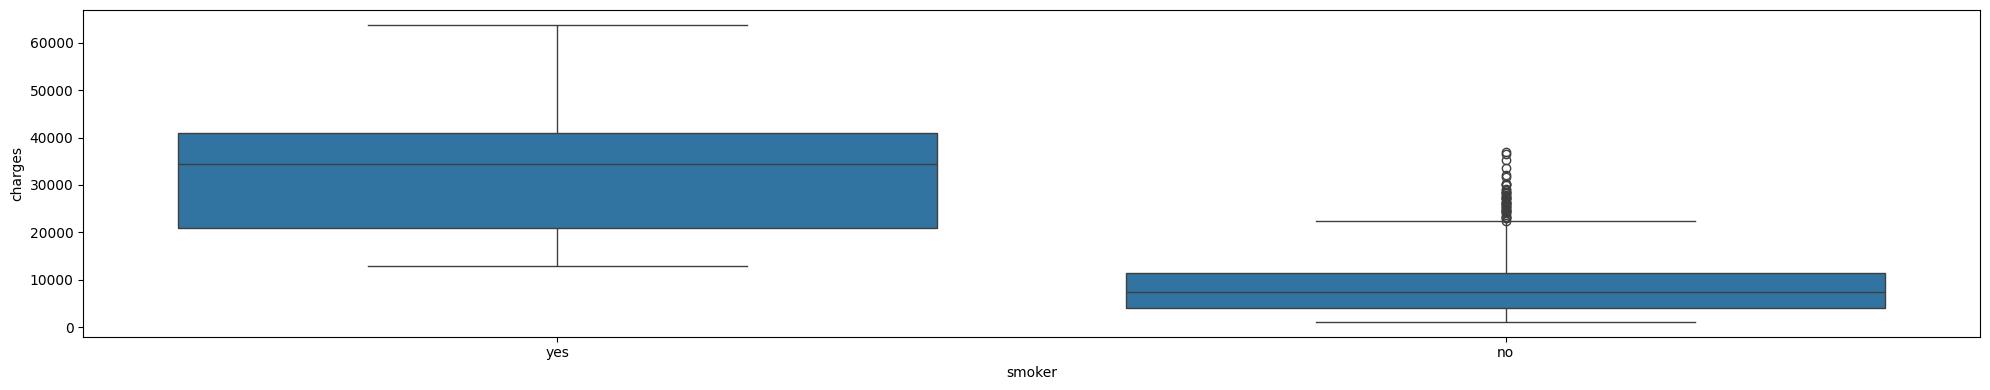

In [492]:
categorical_variables = df.select_dtypes(include=['object']).columns.tolist()
if len(categorical_variables) > 1:
    fig, axis = plt.subplots(len(categorical_variables), 1, figsize=(20, 4*len(categorical_variables)))

    row = 0
    for var in categorical_variables:
        sns.boxplot(ax=axis[row], data=df, x=var, y="charges")
        row += 1
else:
        fig, axis = plt.subplots(figsize=(20, 4))
        var = categorical_variables[0]
        sns.boxplot(ax=axis, data=df, x=var, y="charges")

plt.tight_layout()
plt.show()

### Observaciones

>Claramente los fumadores cambian el valor de changes.

## Paso 6: Ingeniería de características

### Análisis de outliers

In [493]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


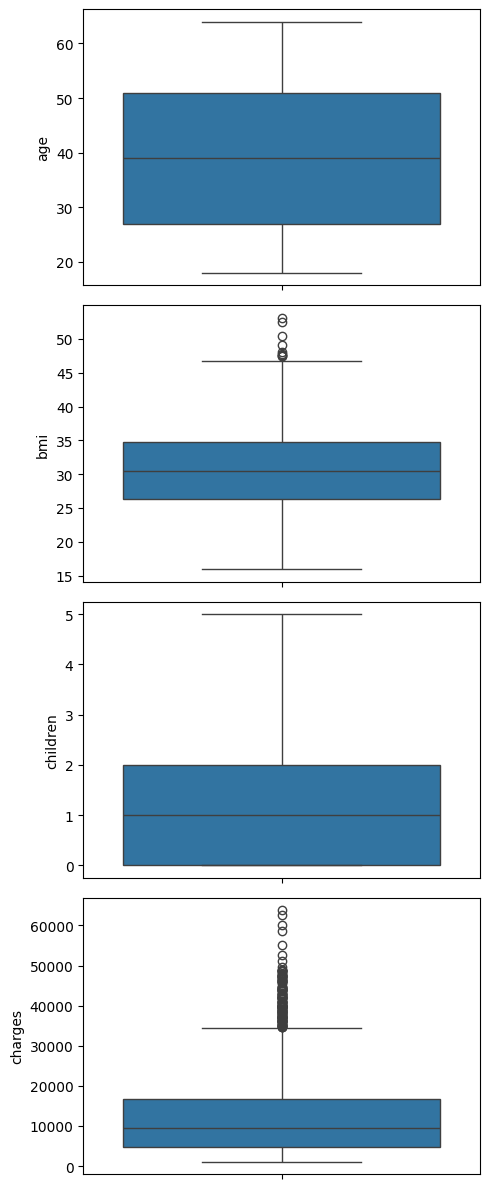

In [494]:
fig, axis = plt.subplots(len(num_variables), 1, figsize=(5, 3*len(num_variables)))

for i, var in enumerate(num_variables):
    sns.boxplot(ax=axis[i], data=df, y=var)


plt.tight_layout()
plt.show()

In [511]:
super_outliners = num_variables
q1 = df[super_outliners].quantile(0.25)
q3 = df[super_outliners].quantile(0.75)
iqr = q3 - q1

# Definir los límites inferior y superior
lower_limit = (q1 - 1.5 * iqr).clip(lower=0)
upper_limit = q3 + 1.5 * iqr

limits = pd.DataFrame({
    "Q1": q1.round(2),
    "Q3": q3.round(2),
    "IQR": iqr.round(2),
    "Lower": lower_limit.round(2),
    "Upper": upper_limit.round(2),
})

limits

,Q1,Q3,IQR,Lower,Upper
age,27.00,51.00,24.00,0.00,87.00
bmi,26.29,34.70,8.41,13.67,47.32
children,0.00,2.00,2.00,0.00,5.00
charges,4746.34,16657.72,11911.37,0.00,34524.78


In [512]:
upper = limits.loc["charges", "Upper"]
outliers = df[df["charges"] > upper]

len_out = len(outliers)
perc_out = len_out / len(df) * 100
len_out, perc_out

(139, 10.396409872849663)

### Observaciones

>No vemos ningún valor irreal. Dejaremos los valores tal como estan.

### Análisis de valores faltantes

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   bmi       1337 non-null   float64
 2   children  1337 non-null   int64  
 3   smoker    1337 non-null   object 
 4   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 52.4+ KB


### Observaciones

> No vemos ningun valor vacio.

### Inferencia de nuevas características

### Observaciones

>No creemos necesario agregar o unificar variables.

## Paso 7: Split (dos métodos o enfoques)

In [496]:
df.shape

(1337, 5)

## Paso 8: Scaling & Encoding

In [497]:
# Dividimos el conjunto de datos en muestras de train y test
X = df.drop("charges", axis=1)
y = df["charges"]

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

In [498]:
X_train.shape

(1069, 4)

In [499]:
y_train.shape

(1069,)

In [500]:
# Genero una lista con los nombres de las columnas categóricas
cat_variables = ["smoker"]

# Creamos la instancia del encoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Entrenamos el encoder con los datos de entrenamiento (ajustamos)
onehot_encoder.fit(X_train[cat_variables])

# Aplicamos el encoder en el conjunto de entrenamiento: X_train
X_train_cat_ohe = onehot_encoder.transform(X_train[cat_variables])
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe,
                               index=X_train.index,
                               columns=onehot_encoder.get_feature_names_out(cat_variables))

# Aplicamos el encoder en el conjunto de test: X_test
X_test_cat_ohe = onehot_encoder.transform(X_test[cat_variables])
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe,
                              index=X_test.index,
                              columns=onehot_encoder.get_feature_names_out(cat_variables))

X_train = X_train.drop(columns=cat_variables)
X_test  = X_test.drop(columns=cat_variables)
X_train = pd.concat([X_train, X_train_cat_ohe], axis=1)
X_test = pd.concat([X_test, X_test_cat_ohe], axis=1)

### Guardando los scalers & encoders

In [501]:
with open('../models/medical-insurance-one-hot-encoder.pkl', 'wb') as file:
    pickle.dump(onehot_encoder, file)

In [502]:
X_train

,age,bmi,children,smoker_no,smoker_yes
1153,48,27.930,4,1.0,0.0
1100,53,28.600,3,1.0,0.0
661,32,31.540,1,1.0,0.0
147,51,37.730,1,1.0,0.0
534,64,40.480,0,1.0,0.0
...,...,...,...,...,...
1198,31,25.800,2,1.0,0.0
837,35,23.465,2,1.0,0.0
1144,52,32.775,3,1.0,0.0
275,47,26.600,2,1.0,0.0


## Paso 9: Creamos y entrenamos el modelo.

In [503]:
def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [507]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [508]:
y_pred = model.predict(X_test)

print(f"Error cuadrático medio: {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación: {r2_score(y_test, y_pred)}")

Error cuadrático medio: 40705440.17481607
Coeficiente de determinación: 0.7180392923598284
